In [ ]:
!unzip "projeto libras"

Archive:  projeto libras.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
  inflating: test/1727879459-5347683_jpg.rf.bc6de7bcf45476c279c59dd67332a676.jpg  
  inflating: test/1727879506-9303179_jpg.rf.826e57f3a9d3a39c852193915f1dbd56.jpg  
  inflating: test/1727879512-1245084_jpg.rf.bf886c7d732d76ac803783ec18522426.jpg  
  inflating: test/1727879583-00178_jpg.rf.3c7f5f0b42ded493c7cb051bd0f82df3.jpg  
  inflating: test/1727879591-3424037_jpg.rf.fbe784dba117c4e4cec8ce56b38a8a39.jpg  
  inflating: test/1727879636-724386_jpg.rf.0d8b2a8de273ca92ca375bc0c954428d.jpg  
  inflating: test/1727879708-7602267_jpg.rf.2cbedc5f7bc929ce1bd30184a3e9cd8f.jpg  
  inflating: test/1727879752-1533523_jpg.rf.e3258f313007ab6dcbc921a956fb48a3.jpg  
  inflating: test/1727879759-4098456_jpg.rf.b7270a67226af184721c190e71180c72.jpg  
  inflating: test/1727879808-4361444_jpg.rf.815264589c4a55de46cc482b72a2114e.jpg  
  inflating: test/1727879812-6177423_jpg.rf.d3db4

In [ ]:
!pip install tensorflow keras pandas matplotlib
!pip install imgaug opencv-python


In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.patches as patches
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import cv2


In [ ]:
def extrair_classes(csv_file):
    df = pd.read_csv(csv_file)
    classes_unicas = sorted(df["class"].unique())
    return {label: idx for idx, label in enumerate(classes_unicas)}

mapa_classes = extrair_classes("train/_annotations.csv")


def carregar_dados(annotation_file, img_dir):
    import pandas as pd
    df = pd.read_csv(annotation_file)

    data = []
    for _, row in df.iterrows():
        image_path = os.path.join(img_dir, row["filename"])
        bbox = [row["xmin"], row["ymin"], row["xmax"], row["ymax"]]
        label = mapa_classes.get(row["class"], -1)


        width = row["width"]
        height = row["height"]

        data.append((image_path, bbox, label))

    return data


In [ ]:
mapa_classes


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'Ajuda': 11,
 'B': 12,
 'Banheiro': 13,
 'C': 14,
 'Cade': 15,
 'Casa': 16,
 'D': 17,
 'E': 18,
 'Em pe': 19,
 'Eu': 20,
 'F': 21,
 'Febre': 22,
 'G': 23,
 'Gosto': 24,
 'I': 25,
 'L': 26,
 'M': 27,
 'N': 28,
 'O': 29,
 'P': 30,
 'Policial': 31,
 'Q': 32,
 'R': 33,
 'S': 34,
 'T': 35,
 'Te amo': 36,
 'Telefone': 37,
 'Tenho': 38,
 'U': 39,
 'V': 40,
 'Vacina': 41,
 'Voce': 42,
 'W': 43,
 'Y': 44}

In [ ]:
def preprocessar(image_path, bbox, label, img_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    original_height, original_width = tf.shape(image)[0], tf.shape(image)[1]

    bbox = tf.convert_to_tensor(bbox, dtype=tf.float32)
    bbox = bbox / [original_width, original_height, original_width, original_height]  # Normalizar coordenadas retangulos

    image = tf.image.resize(image, img_size)

    # Normalizar (importante por conta da perda iou)
    image = tf.cast(image, tf.float32) / 255.0

    # Mudar os retangulos da imagem para as novas possiveis coordenadas
    new_width = img_size[1]
    new_height = img_size[0]
    bbox = bbox * [new_width, new_height, new_width, new_height]

    bbox = bbox / [new_width, new_height, new_width, new_height]  # normalizar para [0, 1]

    label = tf.convert_to_tensor(label, dtype=tf.int32)
    return image, (bbox, label)

def criar_dataset(data, batch_size=16, img_size=(224, 224)):
    dataset = tf.data.Dataset.from_generator(
        lambda: iter(data),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # nome da imagem
            tf.TensorSpec(shape=(4,), dtype=tf.float32),  # coordenadas do retangulo
            tf.TensorSpec(shape=(), dtype=tf.int32),  # classe
        )
    )
    dataset = dataset.map(lambda img, bbox, lbl: preprocessar(img, bbox, lbl, img_size))
    dataset = dataset.repeat()  # Repetir por que estava com um warning durante execução do modelo
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
dados_treino = carregar_dados("train/_annotations.csv", "train/")
dados_validacao = carregar_dados("valid/_annotations.csv", "valid/")


In [ ]:
train_dataset = criar_dataset(dados_treino)
valid_dataset = criar_dataset(dados_validacao)

In [ ]:
def visualizar_imagens_com_retangulo(image, bbox, label, class_map):
    image = (image * 255).numpy().astype("uint8")
    bbox = bbox.numpy()
    label = label.numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    xmin, ymin, xmax, ymax = bbox * 255 #Denormalizar
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin, label, color='white', backgroundcolor='red')
    plt.show()



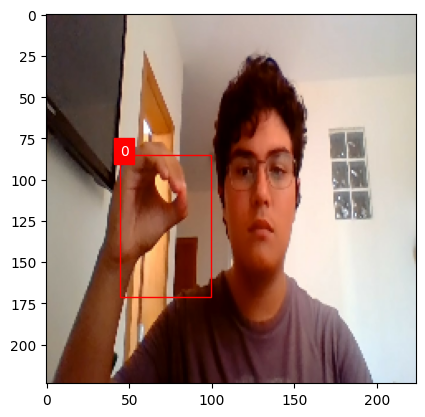

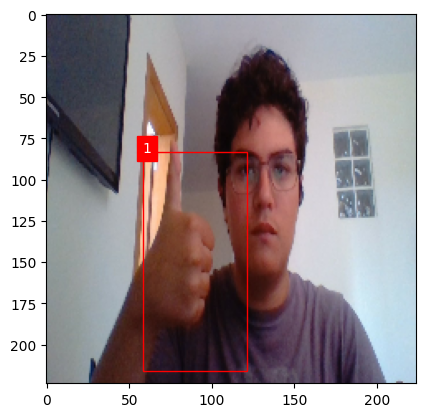

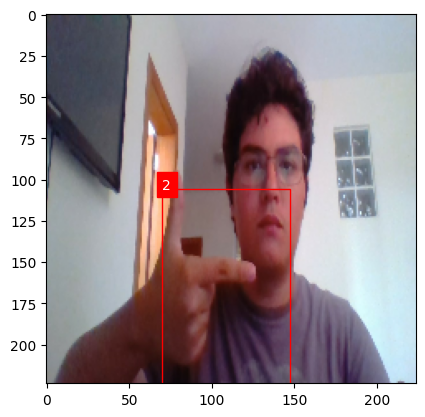

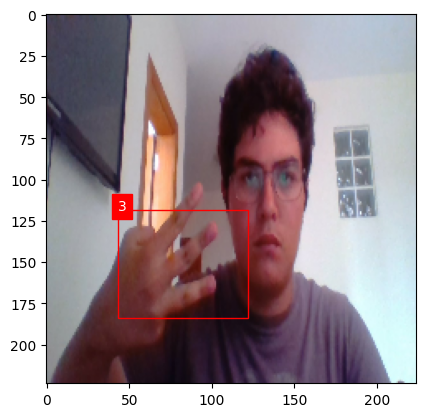

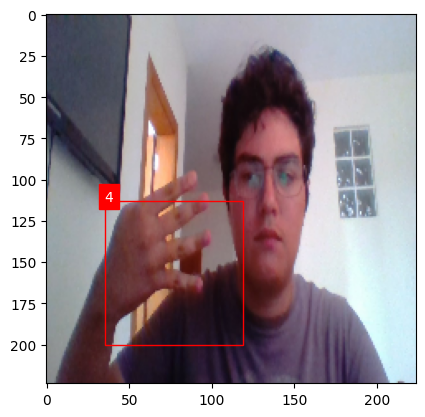

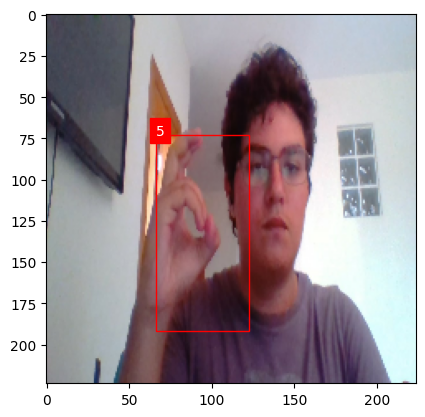

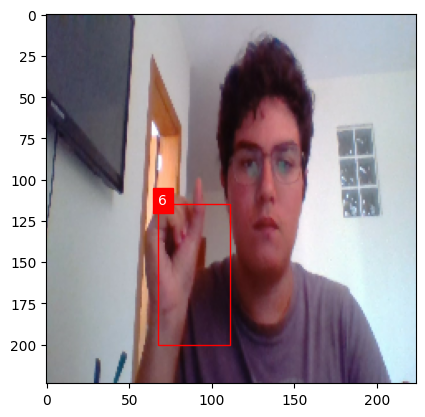

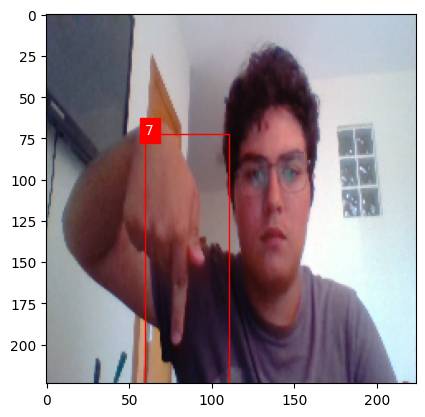

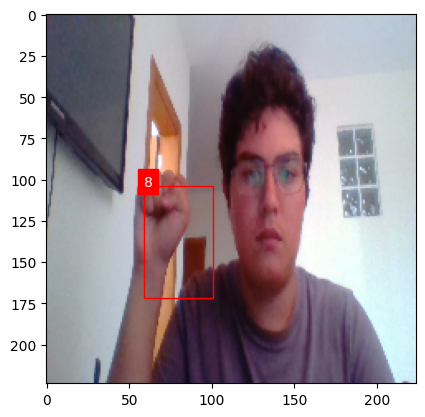

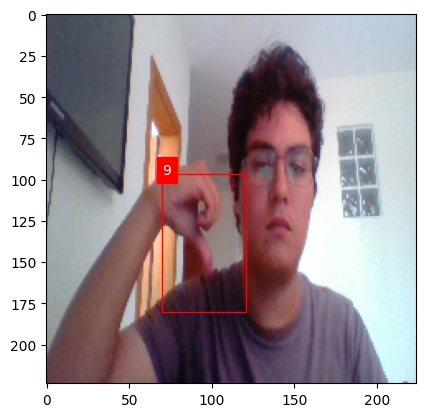

In [ ]:
# Mostrar uma instância de cada dos números e gestos adicionados no dataset
classes_mostradas = set()

for batch in train_dataset:
    images, (bboxes, labels) = batch

    for i in range(len(images)):
        nome_classe = {v: k for k, v in mapa_classes.items()}[labels[i].numpy()]

        if nome_classe in map(str, range(10)) and nome_classe not in classes_mostradas:
            visualizar_imagens_com_retangulo(images[i], bboxes[i], labels[i], {v: k for k, v in mapa_classes.items()})

            classes_mostradas.add(nome_classe)

        if len(classes_mostradas) == 10:
            break

    if len(classes_mostradas) == 10:
        break


In [ ]:
modelo_base = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False) #Modelo vai pegar a base do MobileNetV2, modelo de detecção de objetos bem eficiente
modelo_base.trainable = False

###Esse modelo foi treinado com imagens (224,224,3) por isso foi feito o ajuste para esse tamanho

In [325]:
from tensorflow.keras import regularizers

def criar_modelo(num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = modelo_base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Camada densa para as coordenadas do retangulo com L2 regularization
    x = tf.keras.layers.Dense(128, activation="relu",
                              kernel_regularizer=regularizers.l2(0.01))(x)

    # Dropout para regularizacao
    x = tf.keras.layers.Dropout(0.5)(x)

    # Camada densa para as classes
    class_pred = tf.keras.layers.Dense(num_classes, activation="softmax", name="class")(x)

    # Camada densa para o bbox
    bbox_reg = tf.keras.layers.Dense(4, activation="sigmoid", name="bbox")(x)

    return tf.keras.Model(inputs, [bbox_reg, class_pred])

num_classes = 45
model = criar_modelo(num_classes)


In [335]:
#Função de perda customizada para as coordenadas do retangulo pois o MSquared não estava sendo eficiente
@tf.keras.utils.register_keras_serializable(package='custom', name='giou_loss')
def giou_loss(y_true, y_pred):
    true_xmin, true_ymin, true_xmax, true_ymax = tf.unstack(y_true, axis=-1)
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = tf.unstack(y_pred, axis=-1)

    intersect_xmin = tf.maximum(true_xmin, pred_xmin)
    intersect_ymin = tf.maximum(true_ymin, pred_ymin)
    intersect_xmax = tf.minimum(true_xmax, pred_xmax)
    intersect_ymax = tf.minimum(true_ymax, pred_ymax)

    intersect_width = tf.maximum(0.0, intersect_xmax - intersect_xmin)
    intersect_height = tf.maximum(0.0, intersect_ymax - intersect_ymin)
    intersection_area = intersect_width * intersect_height

    true_area = (true_xmax - true_xmin) * (true_ymax - true_ymin)
    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    union_area = true_area + pred_area - intersection_area

    iou = intersection_area / (union_area + tf.keras.backend.epsilon())

    enclosing_xmin = tf.minimum(true_xmin, pred_xmin)
    enclosing_ymin = tf.minimum(true_ymin, pred_ymin)
    enclosing_xmax = tf.maximum(true_xmax, pred_xmax)
    enclosing_ymax = tf.maximum(true_ymax, pred_ymax)

    enclosing_width = tf.maximum(0.0, enclosing_xmax - enclosing_xmin)
    enclosing_height = tf.maximum(0.0, enclosing_ymax - enclosing_ymin)
    enclosing_area = enclosing_width * enclosing_height

    # GIoU calculo
    giou = iou - (enclosing_area - union_area) / (enclosing_area + tf.keras.backend.epsilon())

    return 1 - giou

@tf.keras.utils.register_keras_serializable(package='custom', name='smooth_l1_loss')
def smooth_l1_loss(y_true, y_pred, beta=1.0):

    diff = tf.abs(y_true - y_pred)
    condition = diff < beta
    loss = tf.where(condition, 0.5 * tf.square(diff), beta * (diff - 0.5))
    return tf.reduce_sum(loss)

In [344]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "bbox": smooth_l1_loss,  # Perda para o retangulo
        "class": "sparse_categorical_crossentropy",  # Perda para as classes
    },
    metrics={"class": "accuracy"}
)


In [345]:
imagens_treino_qt= len([f for f in os.listdir('train') if os.path.isfile(os.path.join('train', f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
imagens_validacao_qt = len([f for f in os.listdir('valid') if os.path.isfile(os.path.join('valid', f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])



In [346]:
# ModelCheckpoint to save the best model
model_checkpoint = ModelCheckpoint(
    filepath="object_detector.keras",  # Save the model to this file
    save_best_only=True,               # Only save the best model
    monitor="val_bbox_loss",                # Monitor validation loss
    mode="min"                         # Minimize the validation loss
)

# ReduceLROnPlateau to adjust the learning rate dynamically
reduce_lr = ReduceLROnPlateau(
    monitor="val_bbox_loss",    # Monitor validation loss
    factor=0.5,            # Reduce learning rate by a factor of 0.5
    patience=10,            # Wait 5 epochs before reducing learning rate
    min_lr=1e-6,           # Set a minimum learning rate
    verbose=1              # Print updates about learning rate reduction
)

# Train the model with the added callbacks
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=150,
    steps_per_epoch=imagens_treino_qt // 16,  # Batch size 16
    validation_steps=imagens_validacao_qt // 16,
    callbacks=[model_checkpoint, reduce_lr]  # Add ReduceLROnPlateau
)


Epoch 1/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - bbox_loss: 0.2560 - class_accuracy: 0.9836 - class_loss: 0.2132 - loss: 0.8521 - val_bbox_loss: 0.1551 - val_class_accuracy: 0.9763 - val_class_loss: 0.1961 - val_loss: 0.7295 - learning_rate: 1.0000e-04
Epoch 2/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - bbox_loss: 0.2270 - class_accuracy: 0.9817 - class_loss: 0.2236 - loss: 0.8281 - val_bbox_loss: 0.1549 - val_class_accuracy: 0.9720 - val_class_loss: 0.1904 - val_loss: 0.7195 - learning_rate: 1.0000e-04
Epoch 3/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - bbox_loss: 0.2305 - class_accuracy: 0.9833 - class_loss: 0.2267 - loss: 0.8307 - val_bbox_loss: 0.1466 - val_class_accuracy: 0.9741 - val_class_loss: 0.1985 - val_loss: 0.7157 - learning_rate: 1.0000e-04
Epoch 4/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - bbox_loss: 0.2272 - class_accuracy: 0.9683 - class_loss: 0.2495 - loss: 0.8465 - val_bbox_loss: 0.1449 - val_class_accuracy: 0.9698 - val_class_loss: 0.1936 - val_loss: 0.

In [347]:

def carregar_imagem(image_path, img_size=(224, 224)):
    imagem = cv2.imread(image_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    image_redimensionada = cv2.resize(imagem, img_size)

    imagem_tensor = tf.convert_to_tensor(image_redimensionada, dtype=tf.float32)

    # Normalizar imagem
    imagem_tensor /= 255.0

    imagem_tensor = tf.expand_dims(imagem_tensor, axis=0)

    return imagem_tensor


In [348]:
def visualizar_predicoes(image_path, bbox_pred, class_pred, img_size=(224, 224)):
    imagem = cv2.imread(image_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    height, width, _ = imagem.shape

    bbox = bbox_pred[0].numpy()
    xmin, ymin, xmax, ymax = bbox

    # Denormalizar coordenadas retangulos
    xmin = int(xmin * width)
    ymin = int(ymin * height)
    xmax = int(xmax * width)
    ymax = int(ymax * height)

    print(bbox)

    # Extrair classe baseado na maior probabilidade
    probabilidade_classes = class_pred[0].numpy()
    classe_id = tf.argmax(probabilidade_classes).numpy()
    nome_classe = ""

    for index, simbolo in mapa_classes.items():

      if simbolo == classe_id:
          nome_classe = index

    fig, ax = plt.subplots(1)
    ax.imshow(imagem)

    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin, nome_classe, color='white', backgroundcolor='red')

    plt.show()


[0.18361576 0.3975217  0.44137022 0.8661144 ]


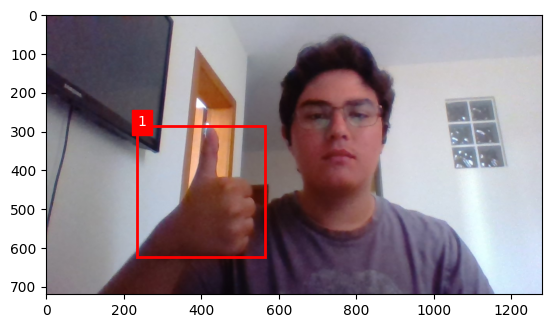

In [349]:
# Carregar modelo treinado
modelo = tf.keras.models.load_model("object_detector.keras")

imagem_tensor = carregar_imagem("test.jpg", img_size=(224, 224))

bbox_pred, classe_pred = modelo(imagem_tensor)
#Testando com imagem não vista pelo modelo (Número 1 em libras)
visualizar_predicoes("test.jpg", bbox_pred, classe_pred)


[0.22654334 0.39282396 0.45559087 0.7124256 ]


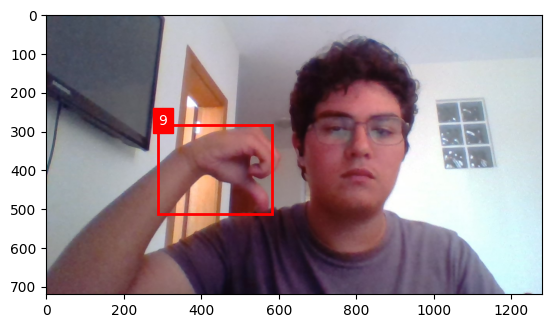

In [350]:
# Carregar modelo treinado
modelo = tf.keras.models.load_model("object_detector.keras")

imagem_tensor = carregar_imagem("test2.jpg", img_size=(224, 224))

bbox_pred, classe_pred = modelo(imagem_tensor)
#Testando com imagem não vista pelo modelo (Número 9 em libras)
visualizar_predicoes("test2.jpg", bbox_pred, classe_pred)

[0.16485444 0.29534426 0.42173204 0.69176716]


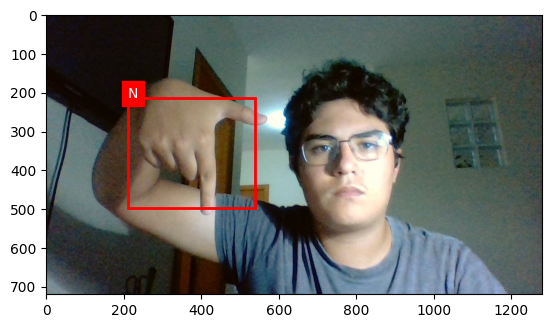

In [351]:
# Carregar modelo treinado
modelo = tf.keras.models.load_model("object_detector.keras")

imagem_tensor = carregar_imagem("test5.jpg", img_size=(224, 224))

bbox_pred, classe_pred = modelo(imagem_tensor)
#Testando com imagem não vista pelo modelo (Número 9 em libras)
visualizar_predicoes("test5.jpg", bbox_pred, classe_pred)

In [352]:
#Com tudo feito é preciso salvar o modelo keras em tflite compatível com a placa TinyML

modelo = tf.keras.models.load_model("object_detector.keras", custom_objects={"iou_loss": smooth_l1_loss})

# Converter o modelo sem quantização
conversor = tf.lite.TFLiteConverter.from_keras_model(modelo)
conversor.optimizations = []  # Não usar otimizações de quantização
tflite_model = conversor.convert()

# Salvar o modelo TFLite
with open("modelo_deteccao_libras.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmplv0dq7nn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_16')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 45), dtype=tf.float32, name=None)]
Captures:
  137842220198096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829709181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829709175216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829709169936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829709171168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829690358096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829706298672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829706292160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829706290048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830019977232: 

In [353]:
# Quantização padrão com pesos e ativações
def representative_data_gen():
    for input_value in train_dataset.take(imagens_treino_qt // 8):
        yield [input_value[0].numpy()]


conversor = tf.lite.TFLiteConverter.from_keras_model(model)

conversor.optimizations = [tf.lite.Optimize.DEFAULT]

conversor.representative_dataset = representative_data_gen


tflite_model = conversor.convert()

with open("modelo_deteccao_libras_quantizado.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp36a_nv39'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_10913')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 45), dtype=tf.float32, name=None)]
Captures:
  137829664167664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829663685296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829663674208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829663671920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829663682832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829663675616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829663676848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829666515680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137829666516736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378296665111

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [354]:
#Testando modelo salvo tflite quantizado (menor acurácia porém maior desempenho no TinyML)

interpretador = tf.lite.Interpreter(model_path="modelo_deteccao_libras.tflite")
interpretador.allocate_tensors()


In [355]:
def visualizar_predicoes_tflite(image_path, bbox_pred, class_pred, img_size=(224, 224)):
    imagem = cv2.imread(image_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    height, width, _ = imagem.shape

    bbox = bbox_pred
    xmin, ymin, xmax, ymax = bbox

    # Denormalizar coordenadas retangulos
    xmin = int(xmin * width)
    ymin = int(ymin * height)
    xmax = int(xmax * width)
    ymax = int(ymax * height)

    print(xmin,ymin,xmax,ymax)

    # Extrair classe baseado na maior probabilidade
    probabilidade_classes = class_pred
    classe_id = tf.argmax(probabilidade_classes).numpy()
    nome_classe = ""

    for index, simbolo in mapa_classes.items():

      if simbolo == classe_id:
          nome_classe = index

    fig, ax = plt.subplots(1)
    ax.imshow(imagem)

    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin, nome_classe, color='white', backgroundcolor='red')

    plt.show()


In [356]:
# Obter detalhes da entrada e saída
input_detalhes = interpretador.get_input_details()
output_detalhes = interpretador.get_output_details()

# Exibir os detalhes da entrada e saída
print("Input details:", input_detalhes)
print("Output details:", output_detalhes)


Input details: [{'name': 'serving_default_input_layer_16:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:1', 'index': 184, 'shape': array([ 1, 45], dtype=int32), 'shape_signature': array([-1, 45], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall_1:0', 'index': 182, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parame

Output: [[1.1549876e-02 5.0699586e-01 2.5067374e-01 4.9922034e-02 8.0152592e-03
  2.4011508e-02 1.0132097e-01 8.5218577e-03 6.6075167e-03 9.7520481e-04
  4.0002083e-03 1.0592517e-04 1.0063640e-04 1.8633109e-05 3.1660340e-05
  3.4595036e-04 2.2149840e-04 3.2975775e-05 4.8936636e-04 8.6156529e-04
  9.7506994e-04 1.1327720e-03 1.6848726e-05 1.2989555e-04 3.6388793e-04
  6.6609918e-03 3.7640810e-05 4.1976389e-03 7.2581251e-04 4.5154785e-04
  2.1928897e-04 1.2570454e-05 9.4911933e-04 1.7458382e-04 1.2599344e-03
  1.7201825e-03 6.6766219e-04 2.5844568e-04 7.0992531e-04 2.1554338e-04
  1.0707772e-03 4.1259453e-05 9.0822479e-04 8.2514563e-04 1.4728919e-03]]
14 365 320 35


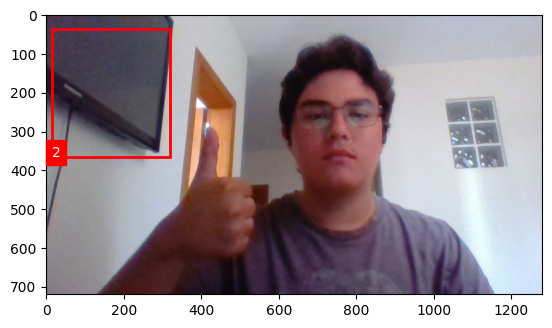

In [358]:
input_data =carregar_imagem("test3.jpg", img_size=(224, 224))
interpretador.set_tensor(input_detalhes[0]['index'], input_data)

interpretador.invoke()

output_data = interpretador.get_tensor(output_detalhes[0]['index'])
print("Output:", output_data)
bbox_pred = output_data[0, :4]
classe_pred = output_data[0, 4:]

visualizar_predicoes_tflite("test3.jpg", bbox_pred, classe_pred)

